# Link Prediction


In [1]:
from pathlib import Path
from typing import Dict, Tuple
try:
    BASE_PATH = str(Path(__file__, "..", "..", "..").resolve())
    import sys
except NameError:
    import sys
    BASE_PATH = str(Path("..", "..").resolve())

if __name__ == "__main__":
    if BASE_PATH not in sys.path:
        sys.path.insert(0, BASE_PATH)


In [2]:
# import corpus_parser.conll_parser
# import importlib
# importlib.reload(corpus_parser.conll_parser)
import os

from corpus_parser.unified_parser import UnifiedParser
from corpus_parser.conll_parser import ConllParser

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import layers
import keras.backend as K

import json
import pandas
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from link_prediction.models.link_utils import create_lr_annealing_function
from link_prediction.models.attention import apply_attention

In [3]:
# Define model initial params

# INFO_TAG = "persuasive_essays_paragraph"
# INFO_TAG = "persuasive_essays_paragraph_all_linked"
# INFO_TAG = "cdcp"
# INFO_TAG = "drinventor"
INFO_TAG = "abstrct"

DATA_PATH = Path(BASE_PATH, "data/")

# LANGUAGE = "english"
LANGUAGE = "spanish"
if LANGUAGE == "english":
    GLOVE_PATH = Path(DATA_PATH, 'glove.840B.300d.txt')
elif LANGUAGE == "spanish":
    GLOVE_PATH = Path(DATA_PATH, 'glove-sbwc.i25.vec')
else:
    raise Exception("Not supported language")

EXPORT_PATH = Path(DATA_PATH, 'link_prediction', INFO_TAG)
TO_PROCESS_DATADIR = Path(DATA_PATH, 'segmenter_processed', INFO_TAG)
PROCESSED_DATADIR = Path(DATA_PATH, 'link_prediction_processed', INFO_TAG)
DIM = 300

params = {
    'in_production': True,
    
    # Model Training Hyperparameters
    'epochs': 70,
    'batch_size': 20,
    'metrics': ['acc'],
    
    # Ensemble Hyperparameters
    'ensemble_amount': 3,
    
    # Model Hyperparameters
    'dim': DIM,
    'dropout': 0.1,
    'lstm_size': 200,
    'max_distance_encoded': 5,
    'linear_embedders_dims': [50, 50, 50, DIM],
    'regularizer_weight': 0.001,
    'encoder_dense_units': 50,
    'encoder_pool_size': 1, # If 1 no tranformation is made to the input.
    'lstm_units': 25,
    'final_size': 20,
    'residual_size': 50,
    'with_attention': True, # If the attention block is used
    'loss_weights': {
        'relation': 10,
        'source': 1,
        'target': 1,
    },
    
    # Adam Optimizer Hyperparameters
    'lr_alpha': 0.003,
    'lr_kappa': 0.001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    
    # Early Stopping Hyperparameters
    'min_delta': 0,
    'patience': 5,
    
    # Corpus Info
    'corpus_path': str(Path(DATA_PATH, 'projection', INFO_TAG)),
    'glove_path': str(Path(EXPORT_PATH, 'glove.npz')),
    'export_path': str(EXPORT_PATH),
    'model_path': str(EXPORT_PATH / "model"),
    'glove_raw_path': str(Path(GLOVE_PATH)),
    'language': LANGUAGE,
    
    # Vectorizer Hyperparameters
    'sequence_standardize': None,
    'sequence_split': 'whitespace',
    
    # Corpus Hyperparameters
    'max_proposition_distance': 10, # Max distance allowed between argumentation
    'non_related_max_proportion': 0.5, # Max proportion allowed between non related links and the total of links
    
    # Data info
    'to_process_data_path': str(Path(TO_PROCESS_DATADIR)), # Directory with text to be processed
    'processed_data_path': str(Path(PROCESSED_DATADIR)), # Directory to save the processed data
}

params['model_name'] = "model" + ("_attention" if params['with_attention'] else "")

In [4]:
# Load Dataset 

def find_duplicates(dataframe, first, second, group):

    for g, dataframe in dataframe.groupby(by=group):
        rows = [row for _, row in dataframe.iterrows()]
        for i, row in enumerate(rows):
            for row2 in rows[i+1:]:
                if row[first] == row2[second] and row[second] == row2[first]:
                    print("DUPLICATED ROW")
                    print(g)
                    print(row)
                    print(row2)

                
def extract_propositions(params: dict):
    corpus_path = Path(params['corpus_path'])
    
    parser = UnifiedParser()
    
    names = [
        "dev", 
        "test",
        "train",
    ]
    
    relation_tags = set()
    proposition_tags = set()
    
    source_vocabulary = set()
    target_vocabulary = set()
    
    # Max amount of propositions in a document
    max_amount_source_in_doc = 0
    max_amount_target_in_doc = 0
    
    # Max amount of tokens in a proposition
    max_size_in_source_prop = 0
    max_size_in_target_prop = 0
    
    for name in names:
        
        proposition_dict = parser.parse_dir(corpus_path / name)
        
        current_source_arg_units = {
            'prop_id': [], 
            'prop_type': [], 
            'prop_text': [], 
            'file_key': []
        }
        current_target_arg_units = {
            'prop_id': [], 
            'prop_type': [], 
            'prop_text': [], 
            'file_key': []
        }
        current_relations = {
            'prop_id_source': [], 
            'prop_id_target': [], 
            'relation_type': [], 
            'distance': [], 
            'file_key': []
        }

        for key, (args_unit, relations, _) in proposition_dict.items():
            args_unit['file_key'] = [key for _ in range(len(args_unit))]
            args_unit = args_unit[['prop_id', 'prop_type', 'prop_text', 'file_key']]
            
            
            relations = relations[['prop_id_source', 'prop_id_target', 'relation_type']]
            relations['distance'] = relations.aggregate(lambda x: x['prop_id_target']-x['prop_id_source'], axis=1)
            relations['file_key'] = relations.aggregate(lambda x: key, axis=1)
            
            source_prop = args_unit[args_unit['prop_id'].isin(relations['prop_id_source'])]
            target_prop = args_unit[args_unit['prop_id'].isin(relations['prop_id_target'])]
            
            source_vocabulary.update([t for s in source_prop['prop_text'] for t in s.split()])
            target_vocabulary.update([t for s in target_prop['prop_text'] for t in s.split()])
            
            max_size_in_source_prop = max(max_size_in_source_prop, source_prop.aggregate(lambda x: len(x['prop_text'].split()), axis=1).max())
            max_size_in_target_prop = max(max_size_in_target_prop, target_prop.aggregate(lambda x: len(x['prop_text'].split()), axis=1).max())
            
            
            max_amount_source_in_doc = max(max_amount_source_in_doc, len(relations['prop_id_source'].drop_duplicates()))
            max_amount_target_in_doc = max(max_amount_target_in_doc, len(relations['prop_id_target'].drop_duplicates()))
            
            current_source_arg_units['prop_id'].extend(source_prop['prop_id'])
            current_source_arg_units['prop_type'].extend(source_prop['prop_type'])
            current_source_arg_units['prop_text'].extend(source_prop['prop_text'])
            current_source_arg_units['file_key'].extend(source_prop['file_key'])
            
            current_target_arg_units['prop_id'].extend(target_prop['prop_id'])
            current_target_arg_units['prop_type'].extend(target_prop['prop_type'])
            current_target_arg_units['prop_text'].extend(target_prop['prop_text'])
            current_target_arg_units['file_key'].extend(target_prop['file_key'])
            
            current_relations['prop_id_source'].extend(relations['prop_id_source'])
            current_relations['prop_id_target'].extend(relations['prop_id_target'])
            current_relations['relation_type'].extend(relations['relation_type'])
            current_relations['distance'].extend(relations['distance'])
            current_relations['file_key'].extend(relations['file_key'])

            
        # Add Inverse Relations
        inverse_relations = {
            'prop_id_source': current_relations['prop_id_target'].copy(),
            'prop_id_target': current_relations['prop_id_source'].copy(),
            'relation_type': [relation_type + "_Inverse" for relation_type in current_relations['relation_type']],
            'distance': [-distance for distance in current_relations['distance']],
            'file_key': current_relations['file_key'].copy(),
        }
        current_relations['prop_id_source'].extend(inverse_relations['prop_id_source'])
        current_relations['prop_id_target'].extend(inverse_relations['prop_id_target'])
        current_relations['relation_type'].extend(inverse_relations['relation_type'])
        current_relations['distance'].extend(inverse_relations['distance'])
        current_relations['file_key'].extend(inverse_relations['file_key'])
        
        
        current_relations = pandas.DataFrame(current_relations)
        current_source_arg_units = pandas.DataFrame(current_source_arg_units)
        current_target_arg_units = pandas.DataFrame(current_target_arg_units)
        
        # Sanity checks
#         print("NEGATIVE PROP IDs")
#         print("TARGET < 0", current_target_arg_units[current_target_arg_units['prop_id'] < 0])
#         print("SOURCE < 0", current_source_arg_units[current_source_arg_units['prop_id'] < 0])
#         print("RELATION TARGET < 0:", list(current_relations[current_relations['prop_id_target'] < 0]['file_key']))
#         print("RELATION SOURCE < 0:", list(current_relations[current_relations['prop_id_source'] < 0]['file_key']))
#         def check_max(s_t_data, data, max_column, compare_to, title):
#             for file, df in data.groupby(by='file_key'):
#                 maxim = s_t_data[s_t_data['file_key'] == file][max_column].max()
#                 print(title, maxim, file)
#                 print(df[df[compare_to] > maxim])
#         check_max(current_target_arg_units, current_relations, 'prop_id', 'prop_id_target', "RELATION TARGET > max")
#         check_max(current_source_arg_units, current_relations, 'prop_id', 'prop_id_source', "RELATION SOURCE > max")
#         print("BEFORE")
#         find_duplicates(current_relations, 'prop_id_source', 'prop_id_target', 'file_key')

        params[f'{name}_source_propositions'] = current_source_arg_units
        params[f'{name}_target_propositions'] = current_target_arg_units
        params[f'{name}_relations'] = current_relations

        print(name, "relations", len(current_relations))
        print(name, "source argumentative units", len(current_source_arg_units))
        print(name, "target argumentative units", len(current_target_arg_units))

        relation_tags.update(current_relations['relation_type'])
        proposition_tags.update(current_source_arg_units['prop_type'])
        proposition_tags.update(current_target_arg_units['prop_type'])
    

    vocabulary = source_vocabulary.union(target_vocabulary)
    params['vocabulary'] = vocabulary
    print("Vocab size", len(vocabulary))
    
    relation_tags = list(relation_tags)
    proposition_tags = list(proposition_tags)
    print("Relation tags", relation_tags)
    print("Proposition tags", proposition_tags)
    params['relation_tags'] = relation_tags
    params['proposition_tags'] = proposition_tags
    
    max_size_prop = max(max_size_in_source_prop, max_size_in_target_prop)
    max_amount_doc = max(max_amount_source_in_doc, max_amount_target_in_doc)
    params['max_size_prop'] = max_size_prop
    params['max_amount_doc'] = max_amount_doc
    
    print('max_size_prop', max_size_prop)
    print('max_amount_doc', max_amount_doc)

    # Vectorizers
    sequence_vectorizer = layers.TextVectorization(
        output_mode = "int",
        max_tokens = len(vocabulary) + 2, # Plus PAD and UNK
        output_sequence_length = int(max_size_prop),
        standardize = params['sequence_standardize'],
        split = params['sequence_split']
    )
    sequence_vectorizer.adapt(pandas.concat([
        params['train_source_propositions'],
        params['train_target_propositions'],
    ], ignore_index=True)['prop_text'])
    params['sequence_vectorizer'] = sequence_vectorizer
    
    relation_tag_vectorizer = layers.TextVectorization(
        output_mode = "int",
        max_tokens = len(relation_tags) + 2, # Plus PAD and UNK
        output_sequence_length = 1,
        standardize = None,
        split = None
    )
    relation_tag_vectorizer.adapt(relation_tags)
    params['relation_tag_vectorizer'] = relation_tag_vectorizer
    
    proposition_tag_vectorizer = layers.TextVectorization(
        output_mode = "int",
        max_tokens = len(proposition_tags) + 2, # Plus PAD and UNK
        output_sequence_length = 1,
        standardize = None,
        split = None
    )
    proposition_tag_vectorizer.adapt(proposition_tags)
    params['proposition_tag_vectorizer'] = proposition_tag_vectorizer
    
    # One-Hot Encoders
    relation_encoder = layers.CategoryEncoding(
        num_tokens=len(relation_tag_vectorizer.get_vocabulary()), # Plus PAD and UNK
        output_mode="one_hot",
    )
    params['relation_encoder'] = relation_encoder
    
    proposition_encoder = layers.CategoryEncoding(
        num_tokens=len(proposition_tag_vectorizer.get_vocabulary()), # Plus PAD and UNK
        output_mode="one_hot",
    )
    params['proposition_encoder'] = proposition_encoder
    
    
extract_propositions(params)

dev relations 2236
dev source argumentative units 912
dev target argumentative units 418
test relations 5580
test source argumentative units 2226
test target argumentative units 1036
train relations 18874
train source argumentative units 7537
train target argumentative units 3460
Vocab size 10305
Relation tags ['attacks_Inverse', 'supports_Inverse', 'supports', 'attacks']
Proposition tags ['MajorClaim', 'Premise', 'Claim']
max_size_prop 70
max_amount_doc 26


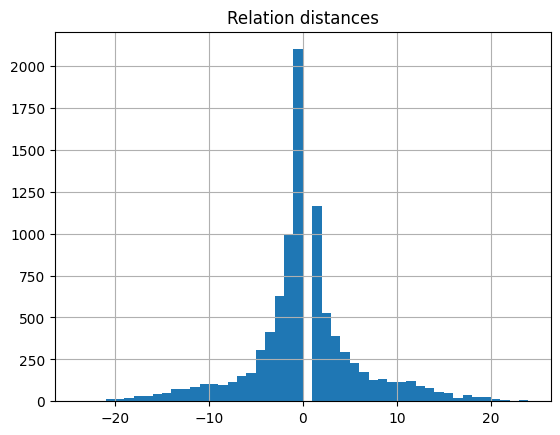

In [5]:
def dataset_statistics(params: dict):
    
    def plot_relation_info(relation_df: pandas.DataFrame):
        relation_df = relation_df[~relation_df['relation_type'].str.endswith("_Inverse")]
        bins = set(relation_df['distance'])
        relation_df['distance'].hist(bins=len(bins))
        plt.title("Relation distances")
        plt.show()
    
    for name in ['train']:
        current_relations = params[f'{name}_relations']

        plot_relation_info(current_relations)
    
dataset_statistics(params)

In [5]:

def creating_glove_embeddings(params: dict):
    
    if Path(params["glove_path"]).exists():
        print("Glove Embedding Matrix Found")
        embedding_matrix = np.load(params["glove_path"])["embeddings"]
        params['embedding_matrix'] = embedding_matrix
        return
    
    # Loading Glove
    hits = 0
    embedding_dim = params['dim']
    word_to_index = dict(map(lambda x: (x[1], x[0]), enumerate(params['sequence_vectorizer'].get_vocabulary())))
    num_tokens = len(word_to_index) # Plus padding and unknown 

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    with Path(params["glove_raw_path"]).open() as f:
        for line_idx, line in enumerate(f):
            if line_idx % 100000 == 0:
                print('- At line {}'.format(line_idx))
            line = line.strip().split()
            if len(line) != 300 + 1:
                continue
            word = line[0]
            embedding = line[1:]
            if word in word_to_index:
                hits += 1
                word_idx = word_to_index[word]
                embedding_matrix[word_idx] = embedding
                
    print('- Done. Found {} vectors for {} words'.format(hits, num_tokens - 2))
    
    params['embedding_matrix'] = embedding_matrix
    Path(params["glove_path"], "..").resolve().mkdir(exist_ok=True, parents=True)
    np.savez_compressed(params["glove_path"], embeddings=embedding_matrix)

creating_glove_embeddings(params)

Glove Embedding Matrix Found


## Building Datasets

In [6]:
# Encode Dataset

def encode_distance(distance, encode_size):
    """
    return: Tensor with the encoded distance
    """
    middle = encode_size // 2

    abs_distance = tf.cast(tf.abs(distance), dtype="int32") 
    zeros = tf.zeros((tf.maximum(1, abs_distance), middle))

    to_sum = tf.concat([zeros, tf.eye(abs_distance, num_columns=middle)], axis=0)
    distance_vec = tf.foldl(lambda x, y: tf.add(x, y), to_sum)

    if distance < 0:
        first_vec = tf.reverse(distance_vec, axis=[0])
        second_vec = zeros[0]
    else:
        first_vec = zeros[0]
        second_vec = distance_vec

    return tf.concat([first_vec, second_vec], axis=0)


def encode_datasets(params: dict):
    sequence_vectorizer = params['sequence_vectorizer']
    proposition_tag_vectorizer = params['proposition_tag_vectorizer']
    relation_tag_vectorizer = params['relation_tag_vectorizer']
    proposition_encoder = params['proposition_encoder']
    relation_encoder = params['relation_encoder']
    distance_encoding_bits = params['max_distance_encoded'] * 2
    max_proposition_distance = params['max_proposition_distance']
    non_related_max_proportion = params['non_related_max_proportion']

    df_path = Path(params['export_path'], f'data_df_{max_proposition_distance}.pkl')
    if df_path.exists():
        data_dataframe = pandas.read_pickle(df_path)
        print("INFO: Data Dataframe Found")
    else:
        data_dataframe = pandas.DataFrame(
            columns = [
                'file_key', 
                'source_prop_id', 
                'target_prop_id', 
                'source_prop_text',
                'target_prop_text',
                'source_prop_type',
                'target_prop_type',
                'relation_type', 
                'distance',
                'split',
            ])

        for split in ['dev', 'test', 'train']:

            source_arg_units = params[f'{split}_source_propositions']
            target_arg_units = params[f'{split}_target_propositions']
            relations = params[f'{split}_relations']

            all_arg_units = pandas.concat([source_arg_units, target_arg_units], ignore_index=True)
            all_arg_units = all_arg_units.drop_duplicates()
            all_arg_units = [(file, df) for file, df in all_arg_units.groupby(by='file_key')]
            
            for file_key, file_source_df in all_arg_units:
                file_target_df = file_source_df.copy()
                file_relations = relations[relations['file_key'] == file_key]

                current_file_info = {
                    'file_key': [], 
                    'source_prop_id': [],
                    'target_prop_id': [],
                    'source_prop_text': [],
                    'target_prop_text': [],
                    'source_prop_type': [],
                    'target_prop_type': [],
                    'relation_type': [],
                    'distance': [],
                    'split': [],
                }
                
                for _, source_row in file_source_df.iterrows():
                    source_id = source_row['prop_id']
                    for _, target_row in file_target_df.iterrows():
                        target_id = target_row['prop_id']

                        # Same relations not allowed
                        if source_id == target_id:
                            continue

                        distance = target_id - source_id
                        # Distance is greater than the max alowed distance between propositions
                        if abs(distance) > max_proposition_distance:
                            continue


                        source_target_relation = file_relations[(file_relations['prop_id_target'] == target_id) & (file_relations['prop_id_source'] == source_id)]
                        
                        if len(source_target_relation) == 0:
                            # No related propositions
                            relation_type = '' # No Relation
                            distance = 0 # Mock Distance
                            source_target_relation = pandas.concat([source_target_relation, pandas.DataFrame({
                                'prop_id_source': [source_id],
                                'prop_id_target': [target_id],
                                'relation_type': [relation_type],
                                'distance': [distance],
                                'file_key': [file_key]
                            })])
                            
                        if len(source_target_relation) > 1:
                            print("WARNING: Multiple relation with single source-target pair")
                            print(source_target_relation)

                        for _, relation_row in source_target_relation.iterrows():

                            assert relation_row['distance'] == distance, f"{relation_row['distance']} != {distance}"

                            # Adding data
                            current_file_info['file_key'].append(file_key)
                            current_file_info['source_prop_id'].append(source_id)
                            current_file_info['target_prop_id'].append(target_id)
                            current_file_info['source_prop_text'].append(source_row['prop_text'])
                            current_file_info['target_prop_text'].append(target_row['prop_text'])
                            current_file_info['source_prop_type'].append(source_row['prop_type'])
                            current_file_info['target_prop_type'].append(target_row['prop_type'])
                            current_file_info['relation_type'].append(relation_row['relation_type'])
                            current_file_info['distance'].append(distance)
                            current_file_info['split'].append(split)
                    
                current_file_info = pandas.DataFrame(current_file_info)
                

                data_dataframe = pandas.concat([data_dataframe, current_file_info], ignore_index=True)
        data_dataframe.to_pickle(df_path)

    params['raw_data_dataframe'] = data_dataframe
    print(len(data_dataframe))
    
    # Encoding
    for split, data_dataframe in data_dataframe.groupby(by="split"):
        
        relation_counter = Counter(data_dataframe['relation_type'])
        
        non_related_proportion = relation_counter[''] / len(data_dataframe)
        if non_related_proportion > non_related_max_proportion:
            amount_to_drop = int((relation_counter[''] - non_related_max_proportion * len(data_dataframe)) / (1 - non_related_max_proportion))
            index = list(data_dataframe[data_dataframe['relation_type'] == ''].index)
            rand.shuffle(index)
            
            data_dataframe = data_dataframe.drop(index[:amount_to_drop])
        
        params[f'raw_{split}_data_dataframe'] = data_dataframe
            
        relation_counter = Counter(data_dataframe['relation_type'])
        print(split, relation_counter)
        
        source_ds = tf.data.Dataset.from_tensor_slices(tf.constant(data_dataframe['source_prop_text'])).map(lambda x: sequence_vectorizer(x))
        target_ds = tf.data.Dataset.from_tensor_slices(tf.constant(data_dataframe['target_prop_text'])).map(lambda x: sequence_vectorizer(x))
        source_type_ds = tf.data.Dataset.from_tensor_slices(tf.constant(data_dataframe['source_prop_type'])).map(lambda x: proposition_encoder(proposition_tag_vectorizer([x])))
        target_type_ds = tf.data.Dataset.from_tensor_slices(tf.constant(data_dataframe['target_prop_type'])).map(lambda x: proposition_encoder(proposition_tag_vectorizer([x])))
        relation_type_ds = tf.data.Dataset.from_tensor_slices(tf.constant(data_dataframe['relation_type'])).map(lambda x: relation_encoder(relation_tag_vectorizer([x])))
        distance_ds = tf.data.Dataset.from_tensor_slices(list(data_dataframe['distance'].to_numpy(dtype=int))).map(lambda x: encode_distance(x, distance_encoding_bits))
        
        # Order matters
        input_ds = tf.data.Dataset.zip((source_ds, target_ds, distance_ds))
        output_ds = tf.data.Dataset.zip((relation_type_ds, source_type_ds, target_type_ds))
        
        ds = tf.data.Dataset.zip((input_ds, output_ds))
        
        params[f"{split}_ds"] = ds

        
encode_datasets(params)


INFO: Data Dataframe Found
155254
dev Counter({'': 1996, 'supports_Inverse': 890, 'supports': 890, 'attacks': 108, 'attacks_Inverse': 108})
test Counter({'': 4868, 'supports': 2218, 'supports_Inverse': 2218, 'attacks': 216, 'attacks_Inverse': 216})
train Counter({'': 16670, 'supports_Inverse': 7513, 'supports': 7513, 'attacks': 822, 'attacks_Inverse': 822})


## Building the model

Two versions of the model can be buit. The difference is the presence or not of an attention layer.

In [7]:
# Build Model

def build_model(params: dict):
    linear_embedders_dims = params['linear_embedders_dims'] # [50, 50, 50, 300]
    max_sequence_size = params['max_size_prop']
    words_amount = len(params['sequence_vectorizer'].get_vocabulary()) # Plus UNK and Pad
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    regularizer_weight = params['regularizer_weight']
    dropout = params['dropout']
    final_embedding_dimension = params['encoder_dense_units']
    final_layer_size = params['final_size']
    pool_size = params['encoder_pool_size']
    distance_encoding_bits = params['max_distance_encoded'] * 2
    lstm_units = params['lstm_units']
    res_size = params['residual_size']
    relation_amount = len(params['relation_tag_vectorizer'].get_vocabulary()) # Plus UNK and Pad
    proposition_tag_amount = len(params['proposition_tag_vectorizer'].get_vocabulary()) # Plus UNK and Pad
    with_attention = params['with_attention']
    ensemble_amount = params['ensemble_amount']
    
    def build_embedder(max_sequence_size, words_amount, embedding_dim, embedding_matrix, linear_layers_dims, regularizer_weight, dropout):
        """
        Builds a proposition embedder
        """
        
        # Input layer
        int_sequence_input = keras.Input(
            shape=(max_sequence_size,), 
            dtype="int64"
        )

        # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
        embedding_layer = layers.Embedding(
            words_amount,
            embedding_dim,
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=False,
            input_length=max_sequence_size,
        )

        initial_layer = model_layers = embedding_layer(int_sequence_input)

        def get_linear_layer(dense_dim, linear_layer=None):
            """
            Creates a single dense layer for the embedder
            """
            
            if linear_layer is None:
                input_vec = keras.Input(shape=(embedding_dim,))
            else:
                input_vec = linear_layer
            
            linear_layer = layers.Dense(
                units=dense_dim,
                activation=None,
                kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l2(regularizer_weight),
                bias_regularizer=keras.regularizers.l2(regularizer_weight)
            )(input_vec)
            
            linear_layer = layers.BatchNormalization()(linear_layer)
            linear_layer = layers.Dropout(dropout)(linear_layer)
            linear_layer = layers.Activation('relu')(linear_layer)
            return input_vec, linear_layer
        
        # Linear transformation
        linear_input, linear_layer = get_linear_layer(linear_layers_dims[0])
        for dim in linear_layers_dims[1:]:
            _, linear_layer = get_linear_layer(dim, linear_layer)
        linear_layer = keras.Model(inputs=linear_input, outputs=linear_layer)
        
        # Apply linear_layer to each word embedding
        model_layers = layers.TimeDistributed(linear_layer)(model_layers)
        
        # Residual connection
        model_layers = layers.Add()([initial_layer, model_layers])
        
        return int_sequence_input, model_layers
    
    def build_dense_encoder(max_sequence_size, embedding_dim, final_dimension, pool_size, regularizer_weight):
        
        # Input layer
        embedding_inputs = keras.Input(
            shape=(max_sequence_size, embedding_dim)
        )
        
        encoder_layer = embedding_inputs
        
        linear_layer = layers.Dense(
            units=final_dimension,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(regularizer_weight),
            bias_regularizer=keras.regularizers.l2(regularizer_weight)
        )
        
        # Apply linear_layer to each word embedding
        encoder_layer = layers.TimeDistributed(linear_layer)(encoder_layer)
        
        # Average the words embeddings
        encoder_layer = layers.AveragePooling1D(
            pool_size=pool_size,
        )(encoder_layer)
    
        encoder_layer = layers.BatchNormalization()(encoder_layer)
    
        return keras.Model(inputs=embedding_inputs, outputs=encoder_layer)
    
    def build_bilstm_encoder(sequence_size, encoded_dim, lstm_units, dropout, regularizer_weight, return_sequences):

        # Input layer
        embedding_inputs = keras.Input(
            shape=(sequence_size, encoded_dim)
        )
        
        bilstm_layer = layers.Bidirectional(
            layers.LSTM(
                units=lstm_units,
                dropout=dropout,
                recurrent_dropout=dropout,
                kernel_regularizer=keras.regularizers.l2(regularizer_weight),
                recurrent_regularizer=keras.regularizers.l2(regularizer_weight),
                bias_regularizer=keras.regularizers.l2(regularizer_weight),
                return_sequences=return_sequences,
            ),
            merge_mode='mul'
        )(embedding_inputs)
        
        return keras.Model(inputs=embedding_inputs, outputs=bilstm_layer)
    
    def apply_resnet(input_layer, regularizer_weight, res_size, dropout):
        prev_layer = input_layer
        prev_block = prev_layer
        
        layers_dims = (2, 2)
        blocks = layers_dims[0]
        res_layers = layers_dims[1]

        shape = int(np.shape(input_layer)[1])

        for i in range(1, blocks + 1):
            for j in range(1, res_layers):
                prev_layer = layers.BatchNormalization()(prev_layer)

                prev_layer = layers.Dropout(dropout)(prev_layer)

                prev_layer = layers.Activation('relu')(prev_layer)

                prev_layer = layers.Dense(
                    units=res_size,
                    activation=None,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(regularizer_weight),
                    bias_regularizer=keras.regularizers.l2(regularizer_weight),
                )(prev_layer)
            
            prev_layer = layers.BatchNormalization()(prev_layer)

            prev_layer = layers.Dropout(dropout)(prev_layer)

            prev_layer = layers.Activation('relu')(prev_layer)

            prev_layer = layers.Dense(units=shape,
                               activation=None,
                               kernel_initializer='he_normal',
                               kernel_regularizer=keras.regularizers.l2(regularizer_weight),
                               bias_regularizer=keras.regularizers.l2(regularizer_weight),
                               )(prev_layer)

            prev_layer = layers.Add()([prev_block, prev_layer])
            prev_block = prev_layer

        return prev_block
    
    def create_single_model(index):
        """
        Create a single model for the ensemble learning
        """
        
        input_distance = keras.Input(
            shape=(distance_encoding_bits, )
        )

        input_source_embedder, source_embedder = build_embedder(
            max_sequence_size, 
            words_amount, 
            embedding_dim, 
            embedding_matrix, 
            linear_embedders_dims, 
            regularizer_weight, 
            dropout
        )

        input_target_embedder, target_embedder = build_embedder(
            max_sequence_size, 
            words_amount, 
            embedding_dim, 
            embedding_matrix, 
            linear_embedders_dims, 
            regularizer_weight, 
            dropout
        )

        dense_encoder = build_dense_encoder(
            max_sequence_size, 
            embedding_dim, 
            final_embedding_dimension, 
            pool_size, 
            regularizer_weight
        )

        bilstm_encoder = build_bilstm_encoder(
            max_sequence_size, 
            final_embedding_dimension, 
            lstm_units, 
            dropout, 
            regularizer_weight,
            with_attention
        )

        # Apply dense encoder to source and target sequence features
        prev_source_layers = source_layers = dense_encoder(source_embedder)
        prev_target_layers = target_layers = dense_encoder(target_embedder)

        # Apply bilstm encoder to source and target sequence features
        source_layers = bilstm_encoder(source_layers)
        target_layers = bilstm_encoder(target_layers)

        if with_attention:
            source_layers, target_layers = apply_attention(
                input_source_embedder, 
                input_target_embedder,
                prev_source_layers,
                prev_target_layers,
                source_layers,
                target_layers,
                final_layer_size,
                index,
            )

        # Concatenate source and target sequence features with other features 
        model_layers = layers.Concatenate()([source_layers, target_layers, input_distance])
        model_layers = layers.BatchNormalization()(model_layers)
        model_layers = layers.Dropout(dropout)(model_layers)

        # Middle dense layer
        model_layers = layers.Dense(
            units=final_layer_size,
            activation='relu',
            kernel_initializer='he_normal',
            kernel_regularizer=keras.regularizers.l2(regularizer_weight),
            bias_regularizer=keras.regularizers.l2(regularizer_weight),
        )(model_layers)

        # Apply a residual network
        model_layers = apply_resnet(
            model_layers,
            regularizer_weight,
            res_size,
            dropout
        )


        model_layers = layers.BatchNormalization()(model_layers)
        model_layers = layers.Dropout(dropout)(model_layers)

        # Classifiers
        relation_classifier = layers.Dense(
            units=relation_amount,
            activation='softmax',
            name=f"relation_{index}",
        )(model_layers)

        source_classifier = layers.Dense(
            units=proposition_tag_amount,
            activation='softmax',
            name=f"source_{index}",
        )(model_layers)

        target_classifier = layers.Dense(
            units=proposition_tag_amount,
            activation='softmax',
            name=f"target_{index}",
        )(model_layers)

        # Creating final model
        model = keras.Model(
            inputs=(input_source_embedder, input_target_embedder, input_distance),
            outputs=(relation_classifier, source_classifier, target_classifier),
            name=f"{params['model_name']}_{index}"
        )
    
        model.summary()
        
        return model
    
    models = []
    
    for i in range(ensemble_amount):
        model = create_single_model(i)
        models.append(model)
    
    params[params['model_name']] = models

build_model(params)

Model: "model_0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 70, 300)      2595600     ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 70, 300)      2595600     ['input_4[0][0]']                
                                                                                            

                                                                                                  
 batch_normalization_14 (BatchN  (None, 20)          80          ['add_3[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 dropout_13 (Dropout)           (None, 20)           0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 relation_0 (Dense)             (None, 6)            126         ['dropout_13[0][0]']             
                                                                                                  
 source_0 (Dense)               (None, 5)            105         ['dropout_13[0][0]']             
                                                                                                  
 target_0 

 activation_22 (Activation)     (None, 20)           0           ['dropout_25[0][0]']             
                                                                                                  
 dense_26 (Dense)               (None, 50)           1050        ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 50)          200         ['dense_26[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_26 (Dropout)           (None, 50)           0           ['batch_normalization_28[0][0]'] 
                                                                                                  
 activation_23 (Activation)     (None, 50)           0           ['dropout_26[0][0]']             
          

                                                                                                  
 dropout_38 (Dropout)           (None, 50)           0           ['batch_normalization_41[0][0]'] 
                                                                                                  
 activation_33 (Activation)     (None, 50)           0           ['dropout_38[0][0]']             
                                                                                                  
 dense_39 (Dense)               (None, 20)           1020        ['activation_33[0][0]']          
                                                                                                  
 add_10 (Add)                   (None, 20)           0           ['dense_37[0][0]',               
                                                                  'dense_39[0][0]']               
                                                                                                  
 batch_nor

In [8]:

def train_and_save_model(params: dict):
    model_name = params['model_name']
    batch_size = params['batch_size']
    if params['in_production']:
        epochs = params['epochs']
        train_ds = params['train_ds'].batch(batch_size)
        val_ds = params['dev_ds'].batch(batch_size)
        models = params[model_name]
    else:
        epochs = 2 
        train_ds = params['train_ds'].batch(batch_size).take(30)
        val_ds = params['dev_ds'].batch(batch_size).take(10)
        models = params[model_name][:2]
    loss_weights = params['loss_weights']
    lr_alpha = params['lr_alpha']
    lr_kappa = params['lr_kappa']
    relation_amount = len(params['relation_tag_vectorizer'].get_vocabulary())
    proposition_amount = len(params['proposition_tag_vectorizer'].get_vocabulary())
    global_metrics = params['metrics']
    beta_1 = params['beta_1']
    beta_2 = params['beta_2']
    min_delta = params['min_delta']
    patience = params['patience']
  
    def single_train(index, model):
        # Optimizer
        lr_function = create_lr_annealing_function(initial_lr=lr_alpha, k=lr_kappa)
        lr_scheduler = keras.callbacks.LearningRateScheduler(lr_function)
        optimizer = tf.optimizers.Adam(
            learning_rate=lr_function(0),
            beta_1=beta_1,
            beta_2=beta_2,
        )

        # EarlyStopping
        early_stopping = keras.callbacks.EarlyStopping(
            min_delta=min_delta,
            patience=patience,
            verbose=1,
        )

        # Metrics
        metrics = {
            f'relation_{index}': global_metrics.copy(),
            f'source_{index}': global_metrics.copy(),
            f'target_{index}': global_metrics.copy(),
        }
        for name, num_classes in [
                (f'relation_{index}', relation_amount), 
                (f'source_{index}', proposition_amount), 
                (f'target_{index}', proposition_amount)
            ]:

            f1_macro = tfa.metrics.F1Score(
                num_classes=num_classes,
                average='macro',
                name=f'{name}F1Macro',
            )
            metrics[name].extend([
                f1_macro,
            ])
        
        current_loss_weights = {f'{name}_{index}': value for name, value in loss_weights.items()}
        
        model.compile(
            loss='categorical_crossentropy', # Apply this loss function to all outputs
            loss_weights=current_loss_weights, # Weights for the sum of the loss functions
            optimizer=optimizer,
            metrics=metrics
        )

        # Train
        history = model.fit(train_ds,
                      batch_size=batch_size, 
                      epochs=epochs, 
                      validation_data=val_ds,
                      callbacks=[
                          lr_scheduler,
                          early_stopping,
                      ])

        history = history.history
        for key in history:
            values = np.array(history[key]).tolist()
            history[key] = values
        params[f'history_{index}'] = history
        with Path(params['model_path'], f"{model_name}_{index}_history.json").open('w') as f:
            json.dump(history, f)

        model.save(str(Path(params["model_path"], f"{model_name}_{index}")), save_format='tf')

    
    for i, model in enumerate(models):
        single_train(i, model)

train_and_save_model(params)

	NEW LR: 0.003
	NEW LR: 0.003
Epoch 1/70
1667/1667 [==============================] - 625s 361ms/step - loss: 10.4784 - relation_0_loss: 0.6271 - source_0_loss: 0.9791 - target_0_loss: 0.9582 - relation_0_acc: 0.7546 - relation_0_relation_0F1Macro: 0.3531 - source_0_acc: 0.5792 - source_0_source_0F1Macro: 0.2431 - target_0_acc: 0.5939 - target_0_target_0F1Macro: 0.2669 - val_loss: 8.1673 - val_relation_0_loss: 0.4689 - val_source_0_loss: 0.7884 - val_target_0_loss: 0.8000 - val_relation_0_acc: 0.8081 - val_relation_0_relation_0F1Macro: 0.3838 - val_source_0_acc: 0.6576 - val_source_0_source_0F1Macro: 0.3068 - val_target_0_acc: 0.6465 - val_target_0_target_0F1Macro: 0.3102 - lr: 0.0030
	NEW LR: 0.0029970029970029974
Epoch 2/70
1667/1667 [==============================] - 553s 332ms/step - loss: 8.4451 - relation_0_loss: 0.5224 - source_0_loss: 0.8736 - target_0_loss: 0.8336 - relation_0_acc: 0.7970 - relation_0_relation_0F1Macro: 0.3767 - source_0_acc: 0.6193 - source_0_source_0F1Macro:

	NEW LR: 0.002964426877470356
Epoch 13/70
1667/1667 [==============================] - 487s 292ms/step - loss: 6.4382 - relation_0_loss: 0.4202 - source_0_loss: 0.7889 - target_0_loss: 0.7038 - relation_0_acc: 0.8489 - relation_0_relation_0F1Macro: 0.4137 - source_0_acc: 0.6472 - source_0_source_0F1Macro: 0.3043 - target_0_acc: 0.6786 - target_0_target_0F1Macro: 0.3580 - val_loss: 6.9195 - val_relation_0_loss: 0.4616 - val_source_0_loss: 0.7653 - val_target_0_loss: 0.7758 - val_relation_0_acc: 0.8211 - val_relation_0_relation_0F1Macro: 0.3929 - val_source_0_acc: 0.6553 - val_source_0_source_0F1Macro: 0.3229 - val_target_0_acc: 0.6591 - val_target_0_target_0F1Macro: 0.3495 - lr: 0.0030
Epoch 13: early stopping
INFO:tensorflow:Assets written to: /tf/notebooks/data/link_prediction/persuasive_essays_paragraph_all_linked/model/model_0/assets
	NEW LR: 0.003
	NEW LR: 0.003
Epoch 1/70
1667/1667 [==============================] - 415s 235ms/step - loss: 10.6536 - relation_1_loss: 0.6437 - sourc

	NEW LR: 0.0029673590504451044
Epoch 12/70
1667/1667 [==============================] - 393s 236ms/step - loss: 6.6748 - relation_1_loss: 0.4456 - source_1_loss: 0.8106 - target_1_loss: 0.7360 - relation_1_acc: 0.8364 - relation_1_relation_1F1Macro: 0.4050 - source_1_acc: 0.6397 - source_1_source_1F1Macro: 0.2902 - target_1_acc: 0.6685 - target_1_target_1F1Macro: 0.3465 - val_loss: 6.7062 - val_relation_1_loss: 0.4518 - val_source_1_loss: 0.7389 - val_target_1_loss: 0.7599 - val_relation_1_acc: 0.8211 - val_relation_1_relation_1F1Macro: 0.3920 - val_source_1_acc: 0.6688 - val_source_1_source_1F1Macro: 0.3240 - val_target_1_acc: 0.6490 - val_target_1_target_1F1Macro: 0.3506 - lr: 0.0030
	NEW LR: 0.002964426877470356
Epoch 13/70
1667/1667 [==============================] - 397s 238ms/step - loss: 6.6421 - relation_1_loss: 0.4430 - source_1_loss: 0.8066 - target_1_loss: 0.7256 - relation_1_acc: 0.8395 - relation_1_relation_1F1Macro: 0.4072 - source_1_acc: 0.6425 - source_1_source_1F1Macro

	NEW LR: 0.00297914597815293
Epoch 8/70
1667/1667 [==============================] - 382s 229ms/step - loss: 7.0246 - relation_2_loss: 0.4625 - source_2_loss: 0.8294 - target_2_loss: 0.7538 - relation_2_acc: 0.8280 - relation_2_relation_2F1Macro: 0.3990 - source_2_acc: 0.6341 - source_2_source_2F1Macro: 0.2742 - target_2_acc: 0.6565 - target_2_target_2F1Macro: 0.3279 - val_loss: 7.2891 - val_relation_2_loss: 0.4890 - val_source_2_loss: 0.8232 - val_target_2_loss: 0.7913 - val_relation_2_acc: 0.7976 - val_relation_2_relation_2F1Macro: 0.3749 - val_source_2_acc: 0.6285 - val_source_2_source_2F1Macro: 0.3214 - val_target_2_acc: 0.6465 - val_target_2_target_2F1Macro: 0.2931 - lr: 0.0030
	NEW LR: 0.002976190476190476
Epoch 9/70
1667/1667 [==============================] - 386s 231ms/step - loss: 6.9500 - relation_2_loss: 0.4600 - source_2_loss: 0.8227 - target_2_loss: 0.7511 - relation_2_acc: 0.8280 - relation_2_relation_2F1Macro: 0.3988 - source_2_acc: 0.6367 - source_2_source_2F1Macro: 0.

In [8]:
# Load Model
def load_saved_model(params: dict):
    ensemble_amount = params['ensemble_amount']
    
    model_name = params["model_name"]
    models = []
    for i in range(ensemble_amount):        
        model_path = Path(params["model_path"], f"{model_name}_{i}")
        if model_path.exists():
            history_path = Path(params['export_path'], f"{model_name}_{i}_history.json")
            history = json.load(history_path.open())
            params[f'history_{i}'] = history
            model = keras.models.load_model(str(model_path))
            models.append(model)
        else:
            print(f"Model in {model_path} doesn't exist")
    params[model_name] = models

    
load_saved_model(params)

In [9]:
# Evaluate model
def evaluate_model(params: dict):
    models = params[params['model_name']]
    batch_size = params['batch_size']
    test_ds = params['test_ds'].batch(batch_size)
    for i, model in enumerate(models):
        print("Model", i)
        results = model.evaluate(test_ds, batch_size=batch_size)


evaluate_model(params)

Model 0
487/487 [==============================] - 24s 45ms/step - loss: 6.8311 - relation_0_loss: 0.4523 - source_0_loss: 0.7676 - target_0_loss: 0.7773 - relation_0_acc: 0.8282 - relation_0_relation_0F1Macro: 0.3955 - source_0_acc: 0.6624 - source_0_source_0F1Macro: 0.3219 - target_0_acc: 0.6628 - target_0_target_0F1Macro: 0.3395
Model 1
487/487 [==============================] - 22s 44ms/step - loss: 6.7685 - relation_1_loss: 0.4441 - source_1_loss: 0.7660 - target_1_loss: 0.7907 - relation_1_acc: 0.8232 - relation_1_relation_1F1Macro: 0.3919 - source_1_acc: 0.6672 - source_1_source_1F1Macro: 0.3388 - target_1_acc: 0.6403 - target_1_target_1F1Macro: 0.3420
Model 2
487/487 [==============================] - 32s 65ms/step - loss: 6.8579 - relation_2_loss: 0.4506 - source_2_loss: 0.7993 - target_2_loss: 0.7905 - relation_2_acc: 0.8232 - relation_2_relation_2F1Macro: 0.3920 - source_2_acc: 0.6435 - source_2_source_2F1Macro: 0.3102 - target_2_acc: 0.6553 - target_2_target_2F1Macro: 0.324

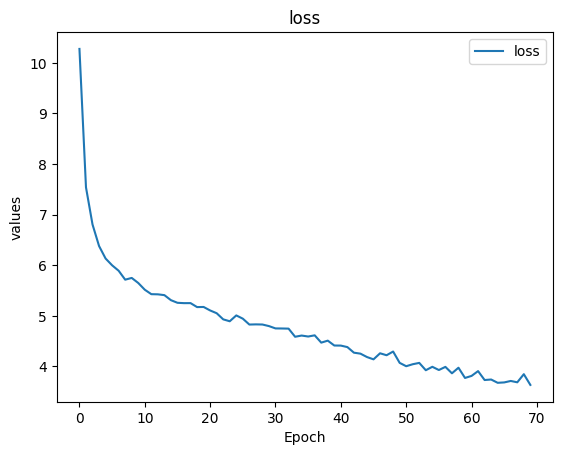

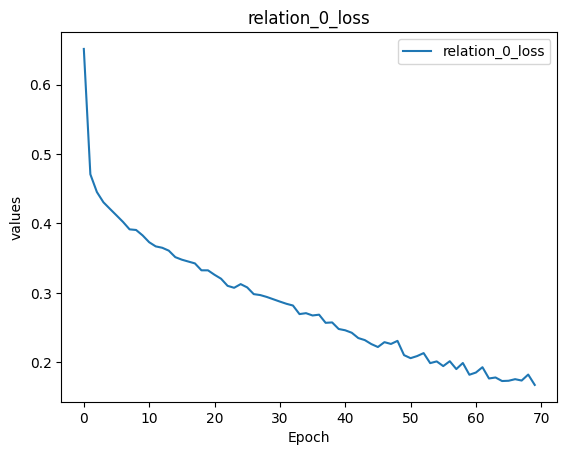

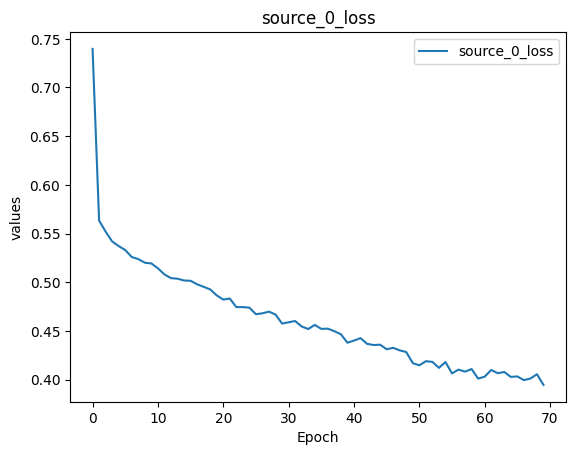

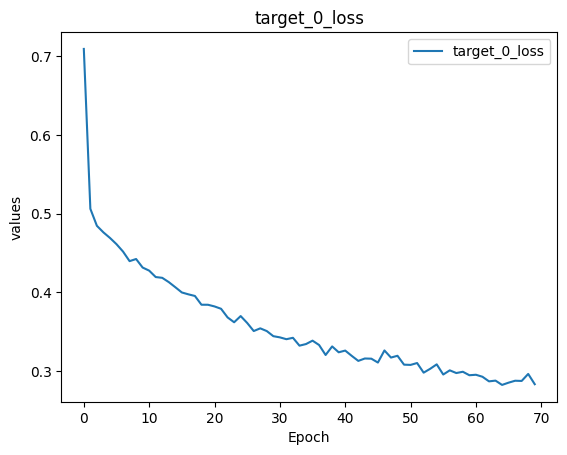

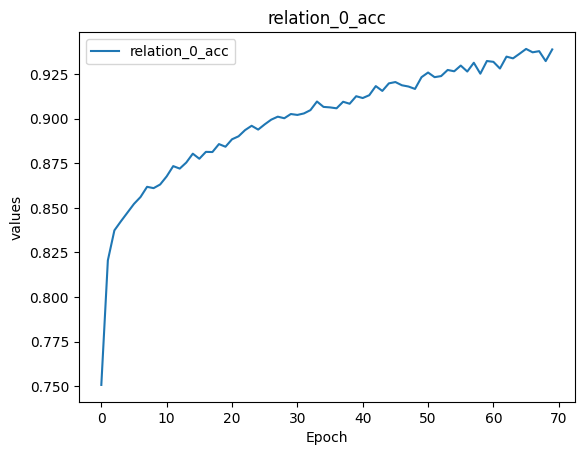

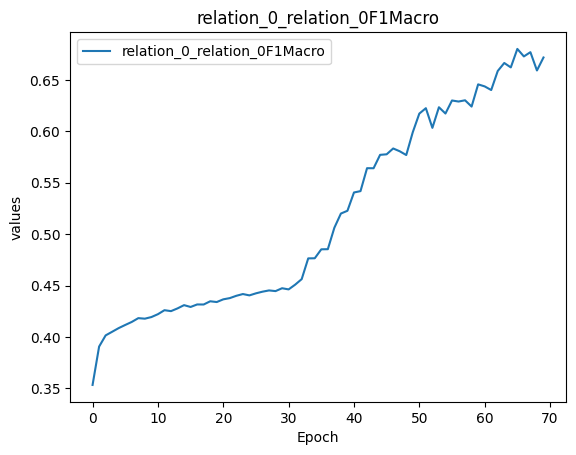

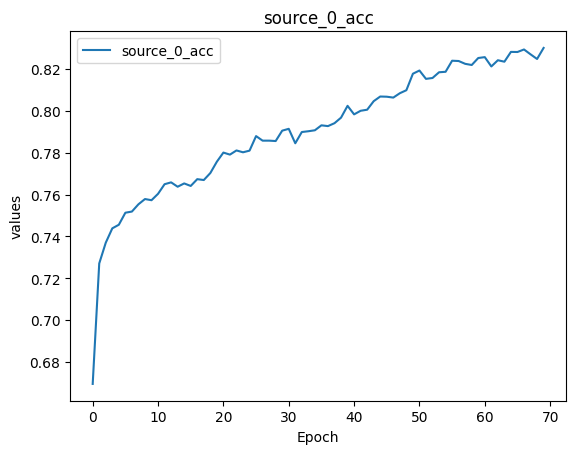

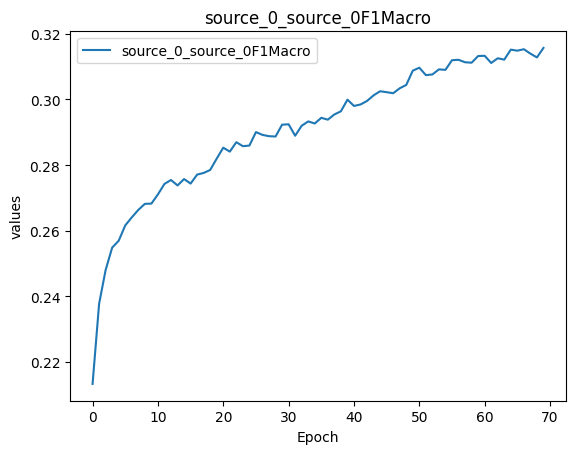

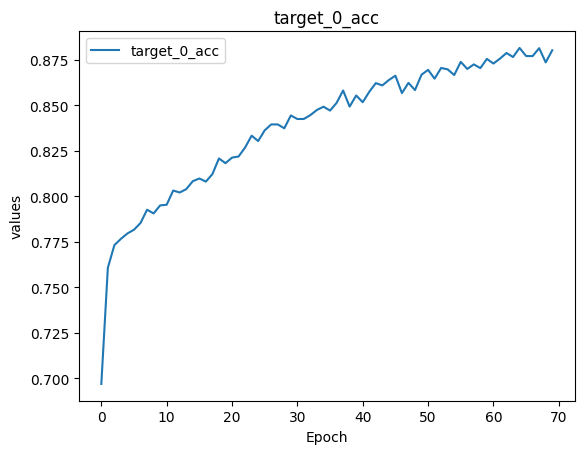

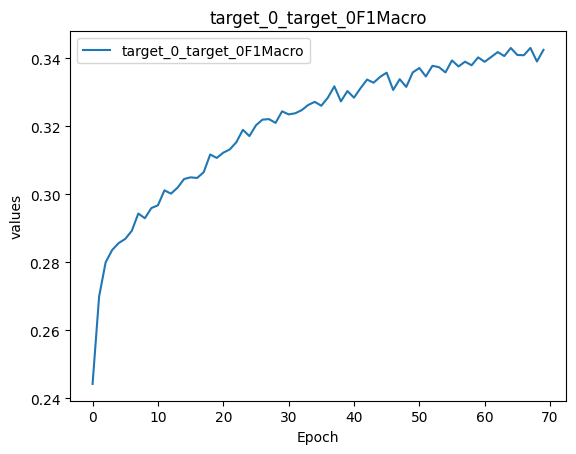

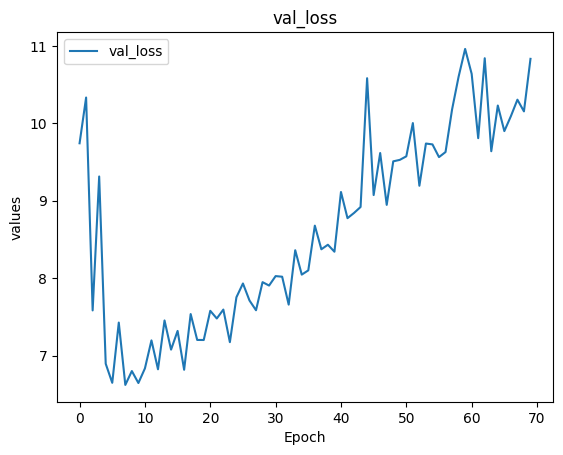

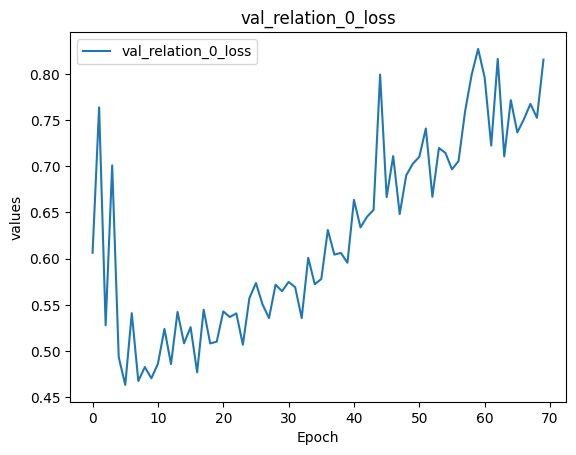

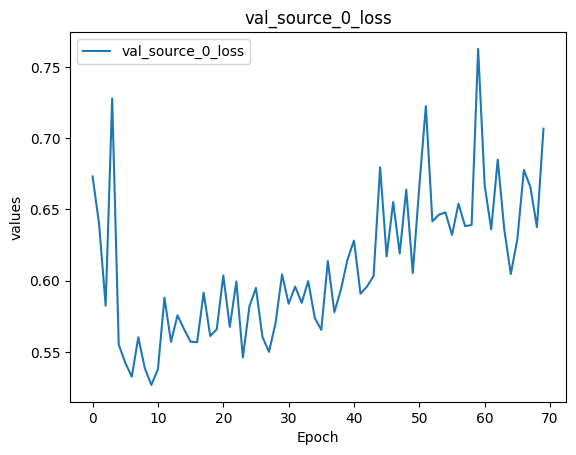

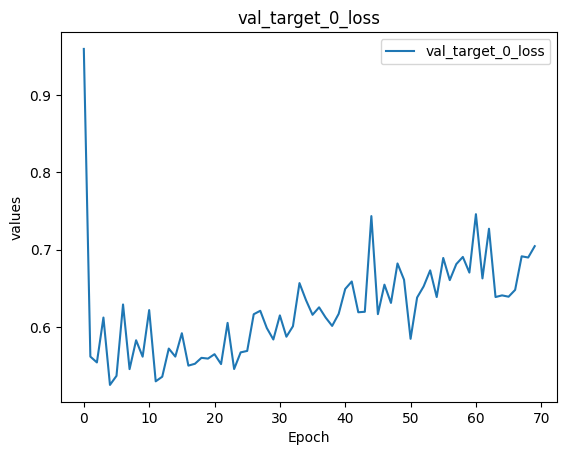

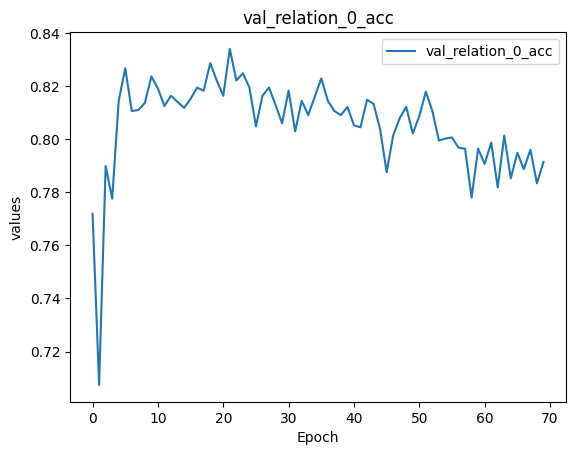

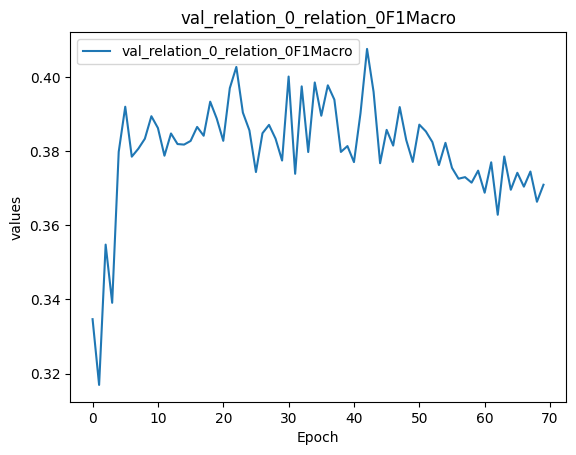

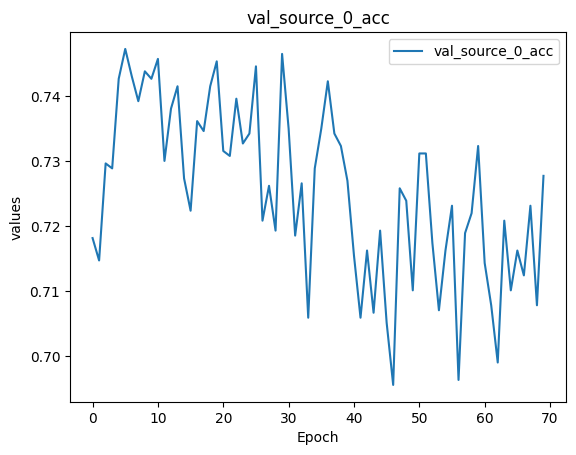

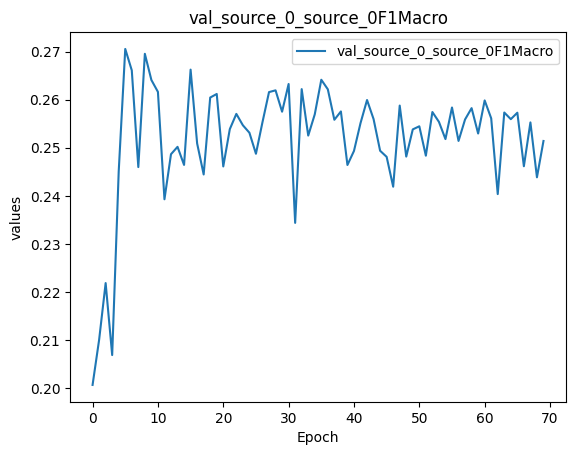

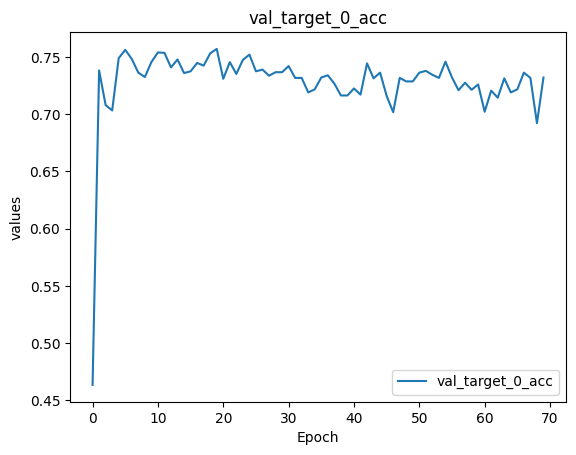

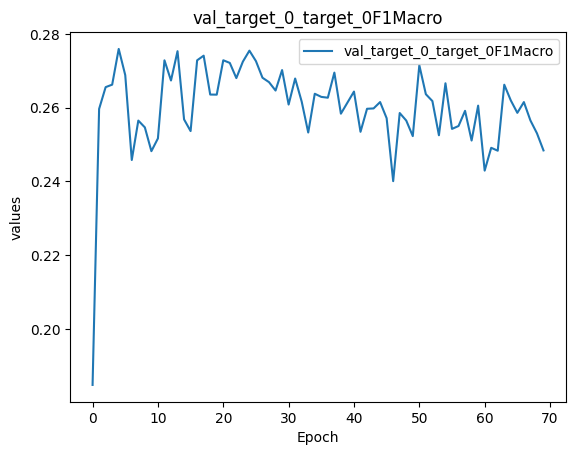

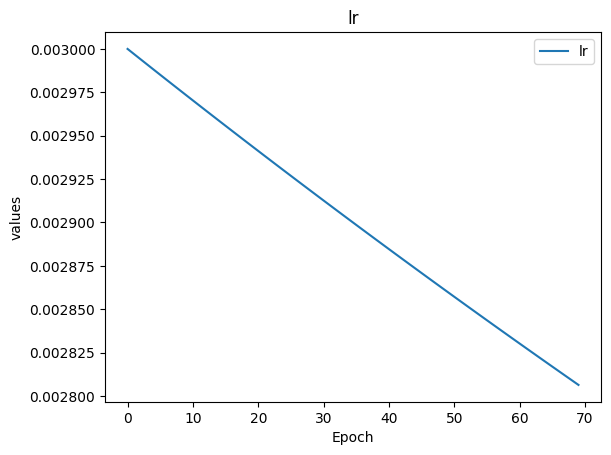

In [10]:
def plot_history(params: dict):
    history = params['history_0']
    relation_labels = [x if x else "None" for x in params['relation_tag_vectorizer'].get_vocabulary()]
    proposition_labels = [x if x else "None" for x in params['proposition_tag_vectorizer'].get_vocabulary()]
        
    def plot_list(values, label):
        X = [i for i in range(len(values))]
        plt.plot(X, values, label=label)
    
    def show_plot(title, x_label="Epoch", y_label=""):
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
        
    def plot_categorical_list(values, labels, bar_plot=False):
        values = np.array(values).T
        plt.xticks(rotation = 45)
        if bar_plot:
            plt.bar(labels, [x[-1] for x in values])
        else:
            for label, label_values in zip(labels, values):
                X = [i for i in range(len(label_values))]
                plt.plot(X, label_values, label=label)
    
    for key, value in history.items():
        value = np.array(value)
        if len(value.shape) == 1: # List values
            plot_list(value, key)
            show_plot(key, y_label="values")
        else: # Categorical values
            labels = relation_labels if 'relation' in key else proposition_labels
            plot_categorical_list(value, labels, bar_plot=True)
            show_plot(key + " bar", x_label='categories', y_label="values")
            plot_categorical_list(value, labels, bar_plot=False)
            show_plot(key, y_label="values")
        
plot_history(params)

In [10]:
class LinkPredictionModel(keras.Model):
    
    def __init__(self,
                 models,
                 sequence_vectorizer, 
                 proposition_tag_vectorizer, 
                 relation_tag_vectorizer, 
                 distance_encoding_bits,
                 batch_size=32
                ):
        super().__init__()
        self.models = models
        self.sequence_vectorizer = sequence_vectorizer
        self.proposition_tag_vectorizer = proposition_tag_vectorizer
        self.relation_tag_vectorizer = relation_tag_vectorizer
        self.distance_encoding_bits = distance_encoding_bits
        self.batch_size = batch_size
    
    def __decode_outputs(self, outputs):
        propositions = self.proposition_tag_vectorizer.get_vocabulary()
        relations = self.relation_tag_vectorizer.get_vocabulary()
        
#         # Flatting results
#         results = []
#         for models_output in outputs:
#             relation = []
#             source = []
#             target = []
#             for i,input_models_output in enumerate(zip(*models_output)):
#                 print(input_models_output)
#                 if i == 0:
#                     current = relation
#                 elif i == 1:
#                     current = source
#                 elif i == 2:
#                     current = target
#                 current.append(list(input_models_output))
                
# #                 for relation_output, source_output, target_output in zip(relation_outputs, source_outputs, target_outputs):
# #                     result.append((relation_output, source_output, target_output))
#             results.append(list(zip(relation, source, target)))
        
        final_result = []
        relation_eye = tf.eye(len(relations))
        proposition_eye = tf.eye(len(propositions))
        for output in zip(*outputs):

            # Reset voting vectors
            relation_tag_tensor = tf.zeros(shape=(len(relations)))
            target_tag_tensor = tf.zeros(shape=(len(propositions)))
            source_tag_tensor = tf.zeros(shape=(len(propositions)))
            
            for relation_output, source_output, target_output in zip(*output):
                # Add the vote for each class
                relation_tag_tensor = tf.add(relation_tag_tensor, relation_eye[tf.argmax(relation_output)])
                target_tag_tensor = tf.add(target_tag_tensor, proposition_eye[tf.argmax(target_output)])
                source_tag_tensor = tf.add(source_tag_tensor, proposition_eye[tf.argmax(source_output)])
            
            # Get the most voted class
            relation_tag = relations[tf.argmax(relation_tag_tensor)]
            target_tag_tensor = propositions[tf.argmax(target_tag_tensor)]
            source_tag_tensor = propositions[tf.argmax(source_tag_tensor)]
            
            final_result.append((relation_tag, source_tag_tensor, target_tag_tensor))
            
        return final_result
    
    def call(self, source_inputs, target_inputs, distance_inputs):
        
        outputs = [[], [], []]
        if source_inputs == [] or target_inputs == [] or distance_inputs == []:
            return outputs

        if len(set([len(source_inputs), len(target_inputs), len(distance_inputs)])) > 1:
            print("WARNING: source_inputs, target_inputs, distance_inputs with different lengths")

        source_ds = tf.data.Dataset.from_tensor_slices(tf.constant(source_inputs)).map(lambda x: self.sequence_vectorizer(x))
        target_ds = tf.data.Dataset.from_tensor_slices(tf.constant(target_inputs)).map(lambda x: self.sequence_vectorizer(x))
        distance_ds = tf.data.Dataset.from_tensor_slices(tf.constant(distance_inputs)).map(lambda x: encode_distance(x, self.distance_encoding_bits))
    
        inputs_ds = tf.data.Dataset.zip((source_ds, target_ds, distance_ds)).batch(self.batch_size)
        
        for inputs in inputs_ds:
            relations = []
            sources = []
            targets = []
            for model in self.models:
                output = model(list(inputs))
                for i, (relation, source, target) in enumerate(zip(*output)):
                    if i == len(relations):
                        relations.append([])
                    relations[i].append(relation)
                    if i == len(sources):
                        sources.append([])
                    sources[i].append(source)
                    if i == len(targets):
                        targets.append([])
                    targets[i].append(target)
            outputs[0].extend(relations)
            outputs[1].extend(sources)
            outputs[2].extend(targets)
        return self.__decode_outputs(outputs)

def build_link_prediction_model(params: dict):
    models = params[params['model_name']]
    sequence_vectorizer = params['sequence_vectorizer']
    proposition_tag_vectorizer = params['proposition_tag_vectorizer']
    relation_tag_vectorizer = params['relation_tag_vectorizer']
    distance_encoding_bits = params['max_distance_encoded'] * 2
    
    
    model = LinkPredictionModel(
        models=models,
        sequence_vectorizer=sequence_vectorizer,
        proposition_tag_vectorizer=proposition_tag_vectorizer,
        relation_tag_vectorizer=relation_tag_vectorizer,
        distance_encoding_bits=distance_encoding_bits
    )
    
    source = "muchos años , la gente tenía que pagar una gran cantidad de dinero prar enviar sus cartas , y sus pagos estaban relacionados con el peso de sus cartas o cajas , y muchos accidentes pueden causar el problema de que el correo no se pueda entregar"
    target = "electrónico puede contarse como uno de los resultados más beneficiosos de la tecnología moderna"
    
    result = model([source, source, source], [target, target, target], [-1, 0 , 1])
    
    print(result)
    print(len(result))

    params[params['model_name'] + "_final"] = model
    
build_link_prediction_model(params)

[('supports', 'Premise', 'Claim'), ('', 'Premise', 'Premise'), ('supports', 'Premise', 'Claim')]
3


In [11]:
def compute_statistic(params: dict):
    model = params[params['model_name'] + "_final"]
    data_dataframe = params[f'raw_test_data_dataframe']

    statistic = {
        'source_prop_text': [],
        'target_prop_text': [],
        'source_prop_type': [],
        'target_prop_type': [],
        'relation_type': [],
        'infered_source_prop_type': [],
        'infered_target_prop_type': [],
        'infered_relation_type': [], 
        'distance': [],
    }
    
    source_ds = tf.data.Dataset.from_tensor_slices(data_dataframe['source_prop_text'])
    target_ds = tf.data.Dataset.from_tensor_slices(data_dataframe['target_prop_text'])
    distance_ds = tf.data.Dataset.from_tensor_slices(list(data_dataframe['distance'].to_numpy(dtype=int)))
    source_tag_ds = tf.data.Dataset.from_tensor_slices(data_dataframe['source_prop_type'])
    target_tag_ds = tf.data.Dataset.from_tensor_slices(data_dataframe['target_prop_type'])
    relation_tag_ds = tf.data.Dataset.from_tensor_slices(data_dataframe['relation_type'])

    batch_num = 1
    for sources, targets, distances, source_tags, target_tags, relation_tags in tf.data.Dataset.zip((source_ds, target_ds, distance_ds, source_tag_ds, target_tag_ds, relation_tag_ds)).batch(32):
        print("batch:", batch_num)
        batch_num += 1
        
        inference = model(sources, targets, distances)
        
        statistic['source_prop_text'].extend([x.numpy().decode() for x in sources])
        statistic['target_prop_text'].extend([x.numpy().decode() for x in targets])
        statistic['source_prop_type'].extend([x.numpy().decode() for x in source_tags])
        statistic['target_prop_type'].extend([x.numpy().decode() for x in target_tags])
        statistic['relation_type'].extend([x.numpy().decode() for x in relation_tags])
        statistic['distance'].extend(distances)
        
        for relation_tag, source_tag, target_tag in inference:
            statistic['infered_source_prop_type'].append(source_tag)
            statistic['infered_target_prop_type'].append(target_tag)
            statistic['infered_relation_type'].append(relation_tag)
        
        if not params['in_production']:
            if batch_num > 10:
                break
    
    statistic = pandas.DataFrame(statistic)
    print(statistic.describe())
    params['statistic'] = statistic
    
compute_statistic(params)

batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100
batch: 1

## Show statistic

- [ ] Calculate consistency (If support or Inverse_support are present its inverse should be present as well)

Accuracy:
Relation Accuracy: 0.8285743631881676
Source Accuracy: 0.6703985209531635
Target Accuracy: 0.6678307313064914
Source Counter: Counter({'Premise': 5494, 'Claim': 3056, 'MajorClaim': 1186})
Target Counter: Counter({'Premise': 5490, 'Claim': 3039, 'MajorClaim': 1207})
Relation Counter: Counter({'': 4868, 'supports': 2218, 'supports_Inverse': 2218, 'attacks': 216, 'attacks_Inverse': 216})
Infered Source Counter: Counter({'Premise': 6398, 'Claim': 2802, 'MajorClaim': 536})
Infered Target Counter: Counter({'Premise': 6060, 'Claim': 2890, 'MajorClaim': 786})
Infered Relation Counter: Counter({'': 4868, 'supports': 2490, 'supports_Inverse': 2378})
Relation
                  precision    recall  f1-score   support

                       1.00      1.00      1.00      4868
         attacks       0.00      0.00      0.00       216
 attacks_Inverse       0.00      0.00      0.00       216
        supports       0.65      0.73      0.69      2218
supports_Inverse       0.66      0.71     

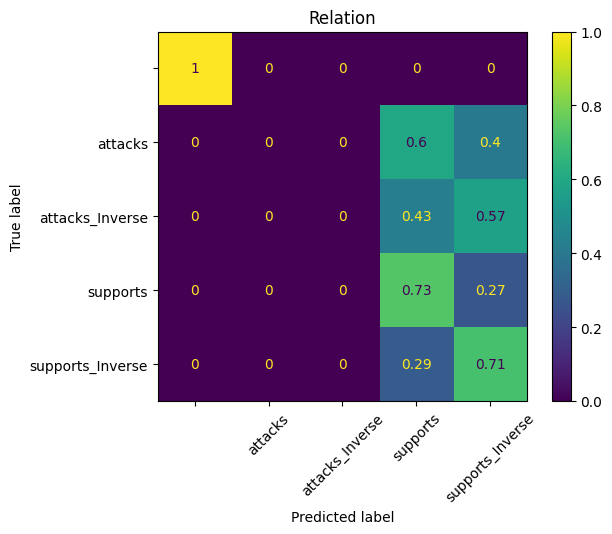

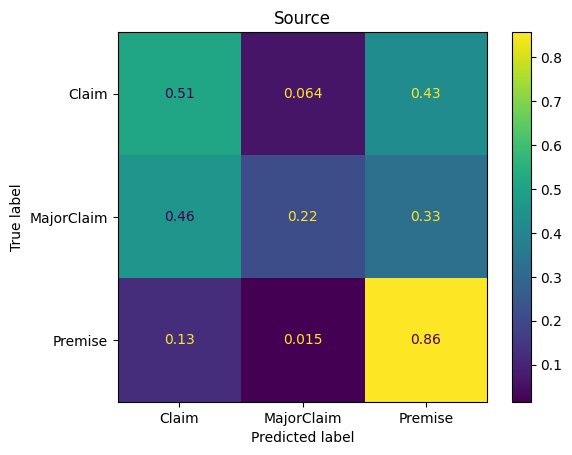

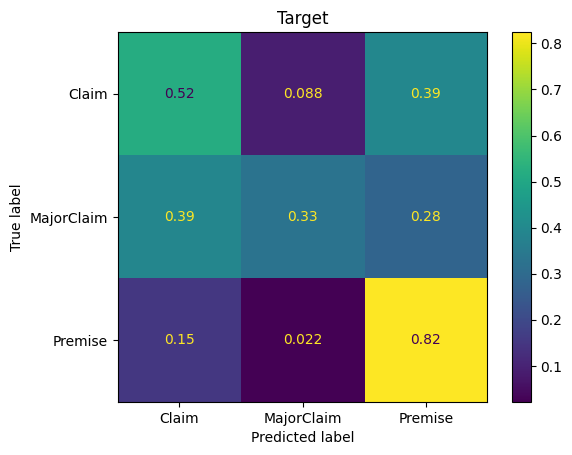

In [13]:

def show_statistic(params: dict):
    statistic = params['statistic']
#     statistic = {
#         'source_prop_text': [],
#         'target_prop_text': [],
#         'source_prop_type': [],
#         'target_prop_type': [],
#         'relation_type': [],
#         'infered_source_prop_type': [],
#         'infered_target_prop_type': [],
#         'infered_relation_type': [], 
#         'distance': [],
#     }
    true_positive_relation = statistic[statistic['relation_type'] == statistic['infered_relation_type']]
    true_positive_source = statistic[statistic['source_prop_type'] == statistic['infered_source_prop_type']]
    true_positive_target = statistic[statistic['target_prop_type'] == statistic['infered_target_prop_type']]
    
#     only_inverse_relations = statistic[statistic['infered_relation_type'].str.endswith("_Inverse")]
#     only_straight_relations = statistic[~statistic['infered_relation_type'].str.endswith("_Inverse")]

#     print(len(only_inverse_relations))
#     print(len(only_straight_relations))
    
#     to_add_straight = {
#         'source_prop_text': [],
#         'target_prop_text': [],
#         'source_prop_type': [],
#         'target_prop_type': [],
#         'relation_type': [],
#         'infered_source_prop_type': [],
#         'infered_target_prop_type': [],
#         'infered_relation_type': [], 
#         'distance': [],
#     }
    
#     def invert_relation_name(name):
#         if name.endswith("_Inverse"):
#             return name[:len("_Inverse")]
#         else:
#             return name + "_Inverse"
#     # Convert straight relations to direct relations
#     for i, row in only_inverse_relations.iterrows():
#         straight_df = only_straight_relations[
#             (only_straight_relations['source_prop_text'] == row['target_prop_text']) 
#           & (only_straight_relations['target_prop_text'] == row['source_prop_text'])]
#         if len(straight_df) == 0:
#             to_add_straight['source_prop_text'].append(row['target_prop_text'])
#             to_add_straight['target_prop_text'].append(row['source_prop_text'])
#             to_add_straight['source_prop_type'].append(row['target_prop_type'])
#             to_add_straight['target_prop_type'].append(row['source_prop_type'])
#             to_add_straight['relation_type'].append(invert_relation_name(row['relation_type']))
#             to_add_straight['infered_source_prop_type'].append(row['infered_target_prop_type'])
#             to_add_straight['infered_target_prop_type'].append(row['infered_source_prop_type'])
#             to_add_straight['infered_relation_type'].append(invert_relation_name(row['infered_relation_type'])) 
#             to_add_straight['distance'].append(-row['distance'])
#         if len(straight_df) == 1:
#             straight_row = straight_df.iloc[0]
#             if 
#         else:
#             pass #print("WARNING: Some propositions have more than one Inverse relation")
    
#     print(f"Added {len(to_add_straight['distance'])} elements from inverse relations")
#     only_straight_relations = pandas.concat([only_straight_relations, pandas.DataFrame(to_add_straight)], ignore_index=True)
    
    print("Accuracy:")
    relation_accuracy = len(true_positive_relation) / len(statistic)
    print("Relation Accuracy:", relation_accuracy)
    source_accuracy = len(true_positive_source) / len(statistic)
    print("Source Accuracy:", source_accuracy)
    target_accuracy = len(true_positive_target) / len(statistic)
    print("Target Accuracy:", target_accuracy)
    
    source_counter = Counter(statistic['source_prop_type'])
    target_counter = Counter(statistic['target_prop_type'])
    relation_counter = Counter(statistic['relation_type'])
    print("Source Counter:", source_counter)
    print("Target Counter:", target_counter)
    print("Relation Counter:", relation_counter)
    
    infered_source_counter = Counter(statistic['infered_source_prop_type'])
    infered_target_counter = Counter(statistic['infered_target_prop_type'])
    infered_relation_counter = Counter(statistic['infered_relation_type'])
    print("Infered Source Counter:", infered_source_counter)
    print("Infered Target Counter:", infered_target_counter)
    print("Infered Relation Counter:", infered_relation_counter)
    
    def plot_confusion_matrix(true_y, pred_y, title, xticks_rotation=0):
        ConfusionMatrixDisplay.from_predictions(true_y, pred_y, normalize="true")
        plt.xticks(rotation = xticks_rotation)
        plt.title(title)
        plt.show()
        
    def sk_f1_report(title, y_true, y_infered):
        print(title)
        print(classification_report(y_true, y_infered, zero_division=0))
    
    def full_report(statistic):
    
        sk_f1_report("Relation", statistic['relation_type'], statistic['infered_relation_type'])
        sk_f1_report("Source", statistic['source_prop_type'], statistic['infered_source_prop_type'])
        sk_f1_report("Target", statistic['target_prop_type'], statistic['infered_target_prop_type'])

        plot_confusion_matrix(statistic['relation_type'], statistic['infered_relation_type'], "Relation", xticks_rotation=45)
        plot_confusion_matrix(statistic['source_prop_type'], statistic['infered_source_prop_type'], "Source")
        plot_confusion_matrix(statistic['target_prop_type'], statistic['infered_target_prop_type'], "Target")
    
    
    full_report(statistic)
    
show_statistic(params)

In [ ]:
def load_and_build_model_from_params(params: dict):
    extract_propositions(params)
    load_saved_model(params)
    build_link_prediction_model(params)
    return params[params['model_name'] + "_final"]

load_and_build_model_from_params(params)

In [ ]:
def train_pipeline(params: dict):
    extract_propositions(params)
    creating_glove_embeddings(params)
    encode_datasets(params)
    build_model(params)
    train_and_save_model(params)


In [ ]:

def process_file(params: dict, content: str, target_file: Path = None, source_language: str="english", source_file: str = None, **kwargs):
    model = params[params['model_name'] + "_final"]
    max_argumentative_distance = params['max_proposition_distance']
    
#     print("Processing", file)
    
    parser = ConllParser(bioes=True)
    argumentative, _, non_argumentative = parser.parse(content)

    source_ids = []
    target_ids = []
    sources = []
    targets = []
    distances = []
    
    predictions: Dict[Tuple[int,int], Tuple[str,str,str]] = {
            
    }

    for _, source in argumentative.iterrows():
        for _, target in argumentative.iterrows():
            distance = target['prop_id'] - source['prop_id']
            if source['prop_id'] == target['prop_id'] or abs(distance) > max_argumentative_distance:
                continue
            source_ids.append(source['prop_id'])
            target_ids.append(target['prop_id'])
            sources.append(source['prop_text'])
            targets.append(target['prop_text'])
            distances.append(distance)

#     print("Inference", file)
#     print(sources)
    inference = model(sources, targets, distances)

    for source_id, target_id, (predicted_relation_tag, predicted_source_tag, predicted_target_tag) in zip(source_ids, target_ids, inference):
        if predicted_relation_tag:
            predictions[source_id, target_id] = predicted_relation_tag, predicted_source_tag, predicted_target_tag

    # Remove inverse relations. If the forward relation doesn't exist then
    # it will be added in either case the inverse relation will be removed.
    to_add = {}
    to_remove = set()
#     print("Removing Inverse relations", file)
    for (source_id, target_id), (predicted_relation_tag, predicted_source_tag, predicted_target_tag) in predictions.items():
        inverse_relation = predicted_relation_tag.endswith("_Inverse")
        if inverse_relation:
            try:
                _ = predictions[target_id, source_id]
            except KeyError:
                # Add the forward relation
                no_inverse_tag = predicted_relation_tag[:-len("_Inverse")]
                to_add[target_id, source_id] = no_inverse_tag, predicted_target_tag, predicted_source_tag
            # Remove inverse relation
            to_remove.add((source_id, target_id))

    # Commit actions to predictions
    for key in to_remove:
        predictions.pop(key)
    predictions.update(to_add)

    # Empty relations table and fill with calculated values
    relation_dict = {
        'relation_id': [],
        'relation_type': [],
        'prop_id_source': [],
        'prop_id_target': [],
    }
    relation_id = 1
    for (source_id, target_id), (predicted_relation_tag, predicted_source_tag, predicted_target_tag) in predictions.items():
        relation_dict['relation_id'].append(relation_id)
        relation_dict['relation_type'].append(predicted_relation_tag)
        relation_dict['prop_id_source'].append(source_id)
        relation_dict['prop_id_target'].append(target_id)
        relation_id += 1
    relations = pandas.DataFrame(relation_dict)

    file_key = "str(file)" if not source_file else source_file
#     print("Parsing from dataframe")
#     print("Relations:", len(relations))
    result = parser.from_dataframes({file_key: (argumentative, relations, non_argumentative)}, source_language=source_language, **kwargs)
    
    if target_file:
        target_file.write_text(result[file_key][0])

    return result[file_key][0]

def use_model(params: dict):
    to_process_dir = params['to_process_data_path']
    processed_data_dir = params['processed_data_path']
    
    segmentation_models = sorted(list(os.walk(to_process_dir))[0][1])
    print(segmentation_models)
    
    for segmentation_model in segmentation_models:
        
        base_path = Path(processed_data_dir) / params['model_name']
        base_path.mkdir(exist_ok=True, parents=True)
        
        current_to_process_dir = Path(to_process_dir, segmentation_model)
        corpus_labels = sorted(list(os.walk(current_to_process_dir))[0][1])
        print(corpus_labels)
        
        for corpus_label in corpus_labels:
            final_current_to_process_dir = current_to_process_dir / corpus_label
            dest_folder = base_path / segmentation_model / corpus_label
            dest_folder.mkdir(exist_ok=True, parents=True)
            
            for file in final_current_to_process_dir.iterdir():
                if file.exists() and file.is_file():
                    dest_file = dest_folder / file.name
                    dest_file.touch(exist_ok=True)
                    process_file(params, file.read_text(), dest_file)
            
use_model(params)

## Export jupyter as module

In [14]:
if __name__ == "__main__":
    from pathlib import Path
    try:
        if Path(__file__).suffix == ".ipynb":
            raise NameError()
    except NameError:
        # In Jupyer Notebook
        from utils.notebook_utils import export_notebook_as_module
        export_notebook_as_module(Path("link_prediction.ipynb"))
